In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !nvidia-smi

In [ ]:
!pip install seqeval -qqq
# TODO: update this notebook to work with the latest version of transformers
!pip install -q transformers==2.11.0

In [ ]:
import tensorflow as tf
tf.__version__

'2.9.2'

#Importing Libraries

In [ ]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint, TensorBoard
from seqeval.metrics import classification_report
from transformers import TFAutoModel
from tensorflow.keras.layers import Dropout, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import shutil
import pickle
from seqeval.metrics import classification_report

from sklearn.model_selection import train_test_split

#Loading Data

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/JP Morgan/Data/translated_set/corrected slot labels data/translated_swa_test_slot_labels.xlsx")

In [ ]:
df.rename(columns = {'utterance_swa	':'words','slot_labels_swa':'word_labels','intent_swa':'intent_label'}, inplace = True)

In [ ]:
df["words"] = df["utterance_swa"]
del df["utterance_swa"]

In [ ]:
df.head()

,utterance_en,slot_labels_en,intent_en,word_labels,intent_label,words
0,what are the flights from tacoma to miami that...,O O O O O B-fromloc.city_name O B-toloc.city_n...,flight,O O O O O O B-kutoka_mji_jina O B-hadi_mji_jin...,ndege,ni safari gani za ndege kutoka tacoma hadi mia...
1,what flights arrive at love field on june sixth,O O O O B-toloc.airport_name I-toloc.airport_n...,flight,O O O O O O O B-hadi_uwanja_wa_ndege_jina I-ha...,ndege,ni ndege gani zinazofika kwenye uwanja wa love...
2,what meals are available on dl 468 which al ar...,O B-meal O O O B-airline_code B-flight_number ...,meal,B-chakula_nambari O O O B-ndege_kanuni B-ndege...,mlo,milo gani inapatikana kwenye dl 468 ambayo ina...
3,list all tower air flights with meals,O O B-airline_name I-airline_name O O B-meal,flight,O O O O B-ndege_jina I-ndege_jina O B-chakula_...,ndege,orodhesha ndege zote za Tower air zina milo
4,at the charlotte airport how many different ty...,O O B-city_name I-city_name O O O O O O O O O ...,aircraft,O O O O O B-mji_jina O O O O O O B-ndege_jina ...,Ndege,kwenye uwanja wa ndege wa charlotte kuna aina ...


In [ ]:
# df_train = df.iloc[:300,5:8] 
# df_valid = df.iloc[350:450,5:8] 
# df_test = df.iloc[450:545,5:8] 
df_train, df_valid = train_test_split(df, test_size=0.2)

In [ ]:
df_train.head()

,utterance_en,slot_labels_en,intent_en,word_labels,intent_label,words
714,tampa to charlotte sunday morning,B-fromloc.city_name O B-toloc.city_name B-depa...,flight,B-kutoka_mji_jina O B-hadi.mji_jina B-kuondoka...,ndege,tampa kwa charlotte jumapili asubuhi
790,what is the seating capacity of the m80,O O O O O O O B-aircraft_code,capacity,O O O O O O B-ndege_kanuni,uwezo,ni uwezo gani wa kuketi wa m80
421,show me the flights between los angeles and da...,O O O O O B-fromloc.city_name I-fromloc.city_n...,flight,O O O O O O B-kutoka_mji_jina I-kutoka_mji_jin...,ndege,nionyeshe safari za ndege kati ya los angeles ...
118,are there any flights from boston to orlando c...,O O O O O B-fromloc.city_name O B-toloc.city_n...,flight,O O O B-kutoka_mji_jina O B-hadi.mji_jina B-ku...,ndege,ndege gani kutoka boston hadi orlando zinazou...
218,i need to take a united airlines flight on jun...,O O O O O B-airline_name I-airline_name O O B-...,flight,O B-ndege_kanuni O O,ndege,nahitaji kuchukua ndege ya shirika la ndege la...


In [ ]:
df_valid.head()

,utterance_en,slot_labels_en,intent_en,word_labels,intent_label,words
383,show me airlines that have flights between tor...,O O O O O O O B-fromloc.city_name O B-toloc.ci...,airline,O O O O O O O O O O O B-kutoka_mji_jina O B-ha...,shirika_la_ndege,nionyeshe mashirika ya ndege ambayo yana safar...
124,i need a flight from st. louis to charlotte,O O O O O B-fromloc.city_name I-fromloc.city_n...,flight,O O O B-kutoka_mji_jina I-kutoka_mji_jina O B-...,ndege,nahitaji ndege kutoka St. Louis hadi charlotte
283,list all flights from cleveland to nashville,O O O O B-fromloc.city_name O B-toloc.city_name,flight,O O O O O O B-kutoka_mji_jina O B-hadi.mji_jina,ndege,orodhesha safari zote za ndege kutoka Clevelan...
63,what cities does northwest fly out of,O O O B-airline_name O O O,city,O O O B-ndege_jina O O,mji,ni miji gani northwest inaruka kutoka
847,what are the flights between cincinnati and sa...,O O O O O B-fromloc.city_name O B-toloc.city_n...,flight,O O O O O O O B-kutoka_mji_jina O B-hadi.mji_j...,ndege,ni safari gani za ndege kati ya cincinnati na ...



## A First Model: Intent Classification (Sentence Level)

Let's ignore the slot filling task for now and let's try to build a sentence level classifier by fine-tuning a pre-trained Transformer-based model using the `huggingface/transformers` package that provides both TF2/Keras and Pytorch APIs.

### The BERT Tokenizer

First let's load a pre-trained tokenizer and test it on a test sentence from the training set:

In [ ]:
from transformers import BertTokenizer
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

#Testing word tokenization using Bert

In [ ]:
first_sentence = df_train.iloc[0]["words"]
first_sentence

'tampa kwa charlotte jumapili asubuhi'

In [ ]:
encoding = tokenizer.encode(first_sentence)
print(tokenizer.convert_ids_to_tokens(encoding))

['[CLS]', 'tam', '##pa', 'kwa', 'char', '##lotte', 'ju', '##ma', '##pili', 'asub', '##uh', '##i', '[SEP]']


It can be noticed that BERT uses subword tokens so the length of the tokenized sentence is likely to be larger than the number of words in the sentence.


Remarks:

- The first token `[CLS]` is used by the pre-training task for sequence classification.
- The last token `[SEP]` is a separator for the pre-training task that classifiies if a pair of sentences are consecutive in a corpus or not (next sentence prediction).

#Data Preprocessing

Checking the length of sequences after tokenization, so that we could assign them to equal dummy vectors in the training set

Text(0.5, 1.0, 'max sequence length: 55')

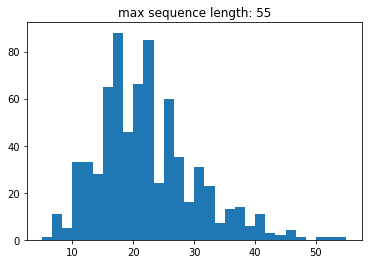

In [ ]:
train_sequence_lengths = [len(tokenizer.encode(text))
                          for text in df_train["words"]]
plt.hist(train_sequence_lengths, bins=30)
plt.title(f"max sequence length: {max(train_sequence_lengths)}")

[link text](https://)The mapping can be introspected in the `tokenizer.vocab` attribute:

### Encoding the Dataset with the Tokenizer

Encoding the full train / valid and test sets with Bert tokenizer to get a padded integer numpy arrays:

In [ ]:
import numpy as np

def encode_dataset(tokenizer, text_sequences, max_length):
    token_ids = np.zeros(shape=(len(text_sequences), max_length),
                         dtype=np.int32)
    for i, text_sequence in enumerate(text_sequences):
        encoded = tokenizer.encode(text_sequence)
        token_ids[i, 0:len(encoded)] = encoded
    attention_masks = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_masks": attention_masks}

encoded_train = encode_dataset(tokenizer, df_train["words"], 60)
encoded_train["input_ids"]

array([[  101, 14918, 11359, ...,     0,     0,     0],
       [  101, 10414,   189, ...,     0,     0,     0],
       [  101, 10414, 16131, ...,     0,     0,     0],
       ...,
       [  101, 16002, 20193, ...,     0,     0,     0],
       [  101, 16002, 20193, ...,     0,     0,     0],
       [  101, 16002, 20193, ...,     0,     0,     0]], dtype=int32)

In [ ]:
encoded_train["attention_masks"]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

In [ ]:
encoded_valid = encode_dataset(tokenizer, df_valid["words"], 60)
# encoded_test = encode_dataset(tokenizer, df_test["words"], 90)

### Encoding the Sequence Classification Targets

To do so we build a simple mapping from the auxiliary files:

In [ ]:
seq_out_tokenizer = Tokenizer(filters='!"#$%&()*+,/:;<=>?@[\\]^`{|}~\t\n', oov_token="UNK",lower=False)

In [ ]:
##Preprocessing

df_train.fillna('O',inplace = True)

df_valid.fillna('O',inplace = True)

In [ ]:
seq_out_tokenizer.fit_on_texts(df_train["word_labels"].tolist())

In [ ]:
seq_out_tokenizer.fit_on_texts(df_valid["word_labels"].tolist())

In [ ]:
seq_out_word_to_index = seq_out_tokenizer.word_index
len(seq_out_word_to_index)

144

In [ ]:
seq_out_word_to_index

{'UNK': 1,
 'O': 2,
 'B-hadi.mji_jina': 3,
 'B-kutoka_mji_jina': 4,
 'I-hadi.mji_jina': 5,
 'B-kuondoka_terehe.siku_jina': 6,
 'I-kutoka_mji_jina': 7,
 'B-ndege_jina': 8,
 'cha': 9,
 'siku': 10,
 'B-kuondoka_muda.kipindi': 11,
 'I-safari_ya_kurudi': 12,
 'B-kutoka.mji_jina': 13,
 'B-hadi_mji_jina': 14,
 'I-kufika_muda.muda': 15,
 'B-ndege_kanuni': 16,
 'I-kuondoka_muda.muda': 17,
 'I-ndege_jina': 18,
 'B-safari_ya_kurudi': 19,
 'B-mji_jina': 20,
 'B-kuondoka_muda.muda_jamaa': 21,
 'B-kuondoka_muda.muda': 22,
 'B-kuondoka_tarehe.siku_jina': 23,
 'B-kufika_muda.muda': 24,
 'I-ndege_acha': 25,
 'I-hadi_mji_jina': 26,
 'B-gharama_jamaa': 27,
 'I-kategoria_aina': 28,
 'B-kuondoka_muda.kipindi_cha_siku': 29,
 'I-kuondoka_terehe.siku_nambari': 30,
 'I-gharama_jamaa': 31,
 'I-kutoka.mji_jina': 32,
 'B-chakula_nambari': 33,
 'B-ndege_mod': 34,
 'B-ndege_acha': 35,
 'I-mji_jina': 36,
 'B-kufika_muda.muda_jamaa': 37,
 'B-kategoria_aina': 38,
 'I-uchumi': 39,
 'B-kuondoka_terehe.mwezi_jina': 40,
 

In [ ]:
intent_names = set(df_train.intent_label)
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))
intent_map

{'siku_jina': 0,
 'umbali': 1,
 'ndege#atis_nauli_ya_ndege': 2,
 'muda_wa_ndege': 3,
 'ndege_nambari#atis_shirika_la_ndege': 4,
 'ufupisho': 5,
 'ndege#atis_shirika_la_ndege': 6,
 'mlo': 7,
 'kiasi': 8,
 'Ndege': 9,
 'ndege_nambari': 10,
 'mji': 11,
 'uwezo': 12,
 'uwanja_wa_ndege': 13,
 'ndege': 14,
 'shirika_la_ndege': 15,
 'nauli_ya_ndege#atis_ndege': 16,
 'huduma_ya_ardhini': 17,
 'nauli_ya_ardhini': 18,
 'nauli_ya_ndege': 19}

In [ ]:
intent_train = df_train["intent_label"].map(intent_map).values

In [ ]:
intent_valid = df_valid["intent_label"].map(intent_map).values

### Loading and Feeding a Pretrained BERT model

Loading a pretrained BERT Large model using the [huggingface transformers](https://github.com/huggingface/transformers) package:

In [ ]:
from transformers import TFAutoModel

large_bert_model = TFAutoModel.from_pretrained("bert-base-multilingual-cased")
large_bert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
Total params: 177,853,440
Trainable params: 177,853,440
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoded_valid

{'input_ids': array([[  101, 10414, 16131, ...,     0,     0,     0],
        [  101, 62137, 10213, ...,     0,     0,     0],
        [  101, 16002, 20193, ...,     0,     0,     0],
        ...,
        [  101, 16002, 20193, ...,     0,     0,     0],
        [  101, 69397, 11856, ...,     0,     0,     0],
        [  101, 11057, 13369, ...,     0,     0,     0]], dtype=int32),
 'attention_masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)}

In [ ]:
outputs = large_bert_model(encoded_valid)
len(outputs)

2

The **first ouput** of the BERT model is a tensor with shape: `(batch_size, seq_len, output_dim)` which computes **features for each token in the input sequence**:

In [ ]:
outputs[0].shape

TensorShape([179, 60, 768])

The **second output** of the BERT model is a tensor with shape `(batch_size, output_dim)` which is the vector representation of the special token `[CLS]`. This vector is typically used as a **pooled representation for the sequence as a whole**.

In [ ]:
outputs[1].shape

TensorShape([179, 768])

#Mapping slots to the corresponding indexes

In [ ]:
slot_names = ["[PAD]"]
slot_names += list(seq_out_word_to_index.keys())[1:]
slot_names

['[PAD]',
 'O',
 'B-hadi.mji_jina',
 'B-kutoka_mji_jina',
 'I-hadi.mji_jina',
 'B-kuondoka_terehe.siku_jina',
 'I-kutoka_mji_jina',
 'B-ndege_jina',
 'cha',
 'siku',
 'B-kuondoka_muda.kipindi',
 'I-safari_ya_kurudi',
 'B-kutoka.mji_jina',
 'B-hadi_mji_jina',
 'I-kufika_muda.muda',
 'B-ndege_kanuni',
 'I-kuondoka_muda.muda',
 'I-ndege_jina',
 'B-safari_ya_kurudi',
 'B-mji_jina',
 'B-kuondoka_muda.muda_jamaa',
 'B-kuondoka_muda.muda',
 'B-kuondoka_tarehe.siku_jina',
 'B-kufika_muda.muda',
 'I-ndege_acha',
 'I-hadi_mji_jina',
 'B-gharama_jamaa',
 'I-kategoria_aina',
 'B-kuondoka_muda.kipindi_cha_siku',
 'I-kuondoka_terehe.siku_nambari',
 'I-gharama_jamaa',
 'I-kutoka.mji_jina',
 'B-chakula_nambari',
 'B-ndege_mod',
 'B-ndege_acha',
 'I-mji_jina',
 'B-kufika_muda.muda_jamaa',
 'B-kategoria_aina',
 'I-uchumi',
 'B-kuondoka_terehe.mwezi_jina',
 'B-kuondoka_terehe.siku_nambari',
 'I-kuondoka_tarehe.siku_nambari',
 'B-kuondoka_tarehe.siku_nambari',
 'B-msimbo_msingi_wa_nauli',
 'B-kuondoka_tar

In [ ]:
slot_map = {}
for label in slot_names:
    slot_map[label] = len(slot_map)
slot_map

{'[PAD]': 0,
 'O': 1,
 'B-hadi.mji_jina': 2,
 'B-kutoka_mji_jina': 3,
 'I-hadi.mji_jina': 4,
 'B-kuondoka_terehe.siku_jina': 5,
 'I-kutoka_mji_jina': 6,
 'B-ndege_jina': 7,
 'cha': 8,
 'siku': 9,
 'B-kuondoka_muda.kipindi': 10,
 'I-safari_ya_kurudi': 11,
 'B-kutoka.mji_jina': 12,
 'B-hadi_mji_jina': 13,
 'I-kufika_muda.muda': 14,
 'B-ndege_kanuni': 15,
 'I-kuondoka_muda.muda': 16,
 'I-ndege_jina': 17,
 'B-safari_ya_kurudi': 18,
 'B-mji_jina': 19,
 'B-kuondoka_muda.muda_jamaa': 20,
 'B-kuondoka_muda.muda': 21,
 'B-kuondoka_tarehe.siku_jina': 22,
 'B-kufika_muda.muda': 23,
 'I-ndege_acha': 24,
 'I-hadi_mji_jina': 25,
 'B-gharama_jamaa': 26,
 'I-kategoria_aina': 27,
 'B-kuondoka_muda.kipindi_cha_siku': 28,
 'I-kuondoka_terehe.siku_nambari': 29,
 'I-gharama_jamaa': 30,
 'I-kutoka.mji_jina': 31,
 'B-chakula_nambari': 32,
 'B-ndege_mod': 33,
 'B-ndege_acha': 34,
 'I-mji_jina': 35,
 'B-kufika_muda.muda_jamaa': 36,
 'B-kategoria_aina': 37,
 'I-uchumi': 38,
 'B-kuondoka_terehe.mwezi_jina': 39,


The following function generates token-aligned integer labels from the BIO word-level annotations. In particular, if a specific word is too long to be represented as a single token, we expand its label for all the tokens of that word while taking care of using "B-" labels only for the first token and then use "I-" for the matching slot type for subsequent tokens of the same word:

In [ ]:
def encode_token_labels(text_sequences, slot_names, tokenizer, slot_map,max_length):
  
    encoded = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int32)
    for i, (text_sequence, word_labels) in enumerate(
            zip(text_sequences, slot_names)):
        encoded_labels = []
        for word, word_label in zip(text_sequence.split(), word_labels.split()):
            tokens = tokenizer.tokenize(word)
            encoded_labels.append(slot_map[word_label])
            expand_label = word_label.replace("B-", "I-")
            if not expand_label in slot_map:
                expand_label = word_label
            encoded_labels.extend([slot_map[expand_label]] * (len(tokens) - 1))
        encoded[i, 1:len(encoded_labels) + 1] = encoded_labels
    return encoded

slot_train = encode_token_labels(
    df_train["words"], df_train["word_labels"], tokenizer, slot_map, 60)
slot_valid = encode_token_labels(
    df_valid["words"], df_valid["word_labels"], tokenizer, slot_map, 60)
# slot_test = encode_token_labels(
#     df_test["words"], df_test["word_labels"], tokenizer, slot_map, 90)

In [ ]:
########################
######### Debbuging proccess

slot_train[0]

array([ 0,  3,  6,  1,  2,  4,  5,  5,  5, 10, 48, 48,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [ ]:
slot_valid[0]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 6,
       6, 1, 2, 4, 1, 1, 3, 6, 1, 2, 4, 4, 1, 1, 1, 3, 6, 6, 1, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
slot_map

{'[PAD]': 0,
 'O': 1,
 'B-hadi.mji_jina': 2,
 'B-kutoka_mji_jina': 3,
 'I-hadi.mji_jina': 4,
 'B-kuondoka_terehe.siku_jina': 5,
 'I-kutoka_mji_jina': 6,
 'B-ndege_jina': 7,
 'cha': 8,
 'siku': 9,
 'B-kuondoka_muda.kipindi': 10,
 'I-safari_ya_kurudi': 11,
 'B-kutoka.mji_jina': 12,
 'B-hadi_mji_jina': 13,
 'I-kufika_muda.muda': 14,
 'B-ndege_kanuni': 15,
 'I-kuondoka_muda.muda': 16,
 'I-ndege_jina': 17,
 'B-safari_ya_kurudi': 18,
 'B-mji_jina': 19,
 'B-kuondoka_muda.muda_jamaa': 20,
 'B-kuondoka_muda.muda': 21,
 'B-kuondoka_tarehe.siku_jina': 22,
 'B-kufika_muda.muda': 23,
 'I-ndege_acha': 24,
 'I-hadi_mji_jina': 25,
 'B-gharama_jamaa': 26,
 'I-kategoria_aina': 27,
 'B-kuondoka_muda.kipindi_cha_siku': 28,
 'I-kuondoka_terehe.siku_nambari': 29,
 'I-gharama_jamaa': 30,
 'I-kutoka.mji_jina': 31,
 'B-chakula_nambari': 32,
 'B-ndege_mod': 33,
 'B-ndege_acha': 34,
 'I-mji_jina': 35,
 'B-kufika_muda.muda_jamaa': 36,
 'B-kategoria_aina': 37,
 'I-uchumi': 38,
 'B-kuondoka_terehe.mwezi_jina': 39,


In [ ]:
# # def encode_token_labels(text_sequences, slot_names, tokenizer, slot_map,max_length):

# text_sequences = df_train["words"]
# slot_names = df_train["word_labels"]
# slot_map = slot_map
# max_length  = 63

# encoded = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int32)
# for i, (text_sequence, word_labels) in enumerate(
#         zip(text_sequences, slot_names)):
#     encoded_labels = []

#     for word, word_label in zip(text_sequence.split(), word_labels.split()):

#         tokens = tokenizer.tokenize(word)
#         # print(word_label)

#         encoded_labels.append(slot_map[word_label])

#         expand_label = word_label.replace("B-", "I-")

#         if not expand_label in slot_map:

#             expand_label = word_label
#         encoded_labels.extend([slot_map[expand_label]] * (len(tokens) - 1))
#     encoded[i, 1:len(encoded_labels) + 1] = encoded_labels

# # print(encoded)

# slot_train = encode_token_labels(
#     df_train["words"], df_train["word_labels"], tokenizer, slot_map, 63)
# slot_valid = encode_token_labels(
#     df_valid["words"], df_valid["word_labels"], tokenizer, slot_map, 63)
# slot_test = encode_token_labels(
#     df_test["words"], df_test["word_labels"], tokenizer, slot_map, 63)

In [ ]:
# df_train["words"][0]

In [ ]:
# df_train["word_labels"][0]

In [ ]:
slot_map['O']

1

Note that the special tokens such as "[PAD]" and "[SEP]" and all padded positions recieve a 0 label.

#Joint Intent And Slot Filling Model

In [ ]:
class JointIntentAndSlotFillingModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, slot_num_labels=None,
                 model_name="bert-base-multilingual-cased", dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFAutoModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)
        self.intent_classifier = Dense(intent_num_labels,
                                       name="intent_classifier")
        self.slot_classifier = Dense(slot_num_labels,
                                     name="slot_classifier")

    def call(self, inputs, training=False):
        sequence_output, pooled_output = self.bert(inputs, training=training)

        # The first output of the main BERT layer has shape:
        # (batch_size, max_length, output_dim)
        sequence_output = self.dropout(sequence_output, training=training)
        slot_logits = self.slot_classifier(sequence_output)

        # The second output of the main BERT layer has shape:
        # (batch_size, output_dim)
        # and gives a "pooled" representation for the full sequence from the
        # hidden state that corresponds to the "[CLS]" token.
        pooled_output = self.dropout(pooled_output, training=training)
        intent_logits = self.intent_classifier(pooled_output)

        return slot_logits, intent_logits

joint_model = JointIntentAndSlotFillingModel(intent_num_labels=len(intent_map), slot_num_labels=len(slot_map))
        
# joint_model.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),loss=losses)


In [ ]:
opt = Adam(learning_rate=3e-5, epsilon=1e-08)
losses = [SparseCategoricalCrossentropy(from_logits=True),
          SparseCategoricalCrossentropy(from_logits=True)]
metrics = [SparseCategoricalAccuracy('accuracy')]
joint_model.compile(optimizer=opt, loss=losses, metrics=metrics)

In [ ]:
history = joint_model.fit(encoded_train, (slot_train, intent_train),validation_data=(encoded_valid, (slot_valid, intent_valid)), epochs=15, batch_size=8)

Epoch 1/15
90/90 [==============================] - 535s 6s/step - loss: 2.0491 - output_1_loss: 0.6802 - output_2_loss: 1.3689 - output_1_accuracy: 0.8692 - output_2_accuracy: 0.7031 - val_loss: 1.5885 - val_output_1_loss: 0.4957 - val_output_2_loss: 1.0928 - val_output_1_accuracy: 0.8986 - val_output_2_accuracy: 0.7374
Epoch 2/15
90/90 [==============================] - 529s 6s/step - loss: 1.4621 - output_1_loss: 0.4856 - output_2_loss: 0.9766 - output_1_accuracy: 0.9037 - output_2_accuracy: 0.7297 - val_loss: 1.0786 - val_output_1_loss: 0.4110 - val_output_2_loss: 0.6676 - val_output_1_accuracy: 0.9166 - val_output_2_accuracy: 0.8492
Epoch 3/15
90/90 [==============================] - 530s 6s/step - loss: 1.0712 - output_1_loss: 0.4064 - output_2_loss: 0.6648 - output_1_accuracy: 0.9215 - output_2_accuracy: 0.8445 - val_loss: 0.9250 - val_output_1_loss: 0.3831 - val_output_2_loss: 0.5419 - val_output_1_accuracy: 0.9244 - val_output_2_accuracy: 0.8603
Epoch 4/15
90/90 [=============

#Making prediction on a single text sequence and displaying both the sequence-wise and the token-wise class labels

In [ ]:
# def show_predictions(text, tokenizer, model, intent_names, slot_names):
  
#     inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
#     outputs = model(inputs)
#     slot_logits, intent_logits = outputs
#     slot_ids = slot_logits.numpy().argmax(axis=-1)[0, 1:-1]
#     intent_id = intent_logits.numpy().argmax(axis=-1)[0]
#     intent = [k for k, v in intent_names.items() if v == intent_id]

#     print("## Intent:", intent)
#     print("## Slots:")
#     for token, slot_id in zip(tokenizer.tokenize(text), slot_ids):
#       # slot = [k for k, v in slot_names.items() if v == slot_ids]
#       # print(token, slot_id)
#       # print(slot_names[slot_id])
#       print(f"{token} : {slot_names[slot_id]}")

#       # break
    
#       # print(f"{token:>10} : {slot_names[slot_id]}")

def show_predictions(text, tokenizer, model, intent_names, slot_names):

    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    # print(inputs)
    outputs = model(inputs)
    slot_logits, intent_logits = outputs
    # print(outputs)
    slot_ids = slot_logits.numpy().argmax(axis=-1)[0, 1:-1]
    # print(slot_ids)
    intent_id = intent_logits.numpy().argmax(axis=-1)[0]
    intent = [k for k, v in intent_names.items() if v == intent_id]

    # print(slot_ids)

    print("## Intent:", intent)
    print("## Slots:")
    slot_pred = []
    
    ####
    text_split = text.split(' ')
    tokens_ids = [(i,j) for i,j in zip(tokenizer.tokenize(text),slot_ids)]
    #### Removing ## Tokens
    tokens_ids_ = [x for x in tokens_ids if not '##' in x[0]]


    for token, slot_id in zip(text_split, tokens_ids_):
      # slot = [k for k, v in slot_names.items() if v == slot_ids]
      # print(token, slot_id)
      # print()
      # print(token)

      # print(token)
      print(f"{token} : {slot_names[slot_id[1]]}")
      slot_pred.append(slot_names[slot_id[1]])

    return intent, slot_pred

      # break
        
      # print(f"{token:>10} : {slot_names[slot_id]}")

In [ ]:
# slot_names

In [ ]:
# df_valid.iloc[0]["words"]
df_valid.iloc[0]["word_labels"]

In [ ]:
pred_intent, pred_slot = show_predictions(df_valid.iloc[0]["words"], tokenizer, joint_model, intent_map, slot_names)

In [ ]:
# pred_slot
from sklearn.metrics import f1_score

avg_f1_score = []

for idx in range(len(df_valid)):
  f1 = f1_score(df_valid.iloc[idx]["word_labels"].split(" "), pred_slot, average="micro")
  avg_f1_score.append(f1)
# df_valid.iloc[0]["word_labels"].split(" "), pred_slot


np.mean(avg_f1_score)

In [ ]:
show_predictions("niyihe funguro zitangwa murugendo rwabanyamerika 811 kuva tampa kugera milwaukee",
                 tokenizer, joint_model, intent_map, slot_names)

In [ ]:
# O O O O B-kuva.umujyi_izina B-igihe_umunsi I-igihe_umunsi O B-kugera.umujyi_izina O   B-igihe_umunsi

In [ ]:
show_predictions("izo ndege zirahaguruka kuwa kabiri kuva montreal zikagera muri chicago mugitondo",
                 tokenizer, joint_model, intent_map, slot_names)

In [ ]:
show_predictions("kwerekana indege kuva burbank kuri st. louis on monday",
                 tokenizer, joint_model, intent_map, slot_names)

In [ ]:
# from transformers import AutoTokenizer, AutoModelForTokenClassification
# from transformers import pipeline
# model_name = 'mbeukman/xlm-roberta-base-finetuned-ner-kinyarwanda'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForTokenClassification.from_pretrained(model_name)

# nlp = pipeline("ner", model=model, tokenizer=tokenizer)
# example = "Ambasaderi wa EU mu Rwanda , Nicola Bellomo yagize ati “ Inkunga yacu ni imwe mu nkunga yagutse yiswe # TeamEurope ."

# ner_results = nlp(example)
# print(ner_results)

In [ ]:
# from transformers import AutoTokenizer, AutoModelForTokenClassification
# from transformers import pipeline

# tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
# model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

# nlp = pipeline("ner", model=model, tokenizer=tokenizer)
# example = "My name is Wolfgang and I live in Berlin"

# ner_results = nlp(example)
# print(ner_results)

In [ ]:
# from transformers import AutoTokenizer, AutoModelForTokenClassification
# from transformers import pipeline
# model_name = 'mbeukman/xlm-roberta-base-finetuned-kinyarwanda-finetuned-ner-kinyarwanda'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForTokenClassification.from_pretrained(model_name)

# nlp = pipeline("ner", model=model, tokenizer=tokenizer)
# example = "Ambasaderi wa EU mu Rwanda , Nicola Bellomo yagize ati “ Inkunga yacu ni imwe mu nkunga yagutse yiswe # TeamEurope ."

# ner_results = nlp(example)
# print(ner_results)


In [ ]:
# XLM and roberta